In [ ]:
! pip install gurobipy

     |████████████████████████████████| 11.5 MB 31.9 MB/s 


In [ ]:
import numpy as np
import gurobipy as gp
import pandas as pd

# Ans 1

In [ ]:
df=pd.read_csv('stocks2019.csv',index_col='X')
df.head(3)

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,ANSS,AAPL,AMAT,ASML,ADSK,ADP,BIDU,BIIB,BMRN,BKNG,AVGO,CDNS,CDW,CERN,CHTR,CHKP,CTAS,CSCO,CTXS,CTSH,CMCSA,CPRT,COST,CSX,DXCM,DOCU,DLTR,EBAY,EA,...,MELI,MCHP,MU,MSFT,MRNA,MDLZ,MNST,NTES,NFLX,NVDA,NXPI,ORLY,PCAR,PAYX,PYPL,PEP,PDD,QCOM,REGN,ROST,SGEN,SIRI,SWKS,SPLK,SBUX,SNPS,TMUS,TTWO,TSLA,TXN,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,6360.870117,46.350380,224.570007,18.830000,98.050003,202.119995,1054.680054,1045.849976,1539.130005,182.458298,82.851608,143.009995,38.629097,32.536137,153.048553,128.960007,125.159172,162.250000,304.690002,84.959999,1721.699951,235.462082,43.230000,77.528900,51.063816,287.98999,103.500000,165.878006,40.382099,99.968712,61.649429,33.121780,47.680000,201.447266,60.481594,115.180000,40.820000,91.199997,28.105513,80.370003,...,298.010010,69.420082,32.750000,98.860214,15.330000,38.419731,48.759998,44.063419,267.660004,135.506561,73.355392,341.149994,54.536522,61.546516,85.750000,103.860535,22.209999,54.205219,372.440002,82.688972,57.490002,5.816079,65.834534,103.320000,62.150398,84.050003,65.260002,104.010002,62.023998,89.888748,27.590000,247.970001,147.759995,107.364159,164.080002,63.920757,159.740005,36.312473,46.041862,84.600266
2019-01-03,6147.129883,44.704514,215.699997,17.049999,100.209999,184.779999,1025.469971,1016.059998,1500.280029,179.681961,77.846962,137.639999,34.781353,30.650827,144.607849,121.849998,121.379601,154.710007,307.000000,84.199997,1663.119995,214.517471,41.529999,75.531197,49.911999,287.50000,102.349998,163.223785,38.913486,98.530945,59.704865,33.381977,46.889999,197.177475,59.534588,112.260002,38.830002,90.760002,27.589191,78.709999,...,296.589996,64.526123,31.000000,95.223351,15.500000,38.275265,48.000000,42.367931,271.200012,127.319656,70.363708,346.130005,53.273495,60.506081,82.089996,102.891121,21.520000,52.599842,372.079987,81.998093,56.369999,5.855510,58.820972,100.809998,59.454502,81.110001,65.019997,99.150002,60.071999,84.587738,26.959999,243.360001,142.589996,104.083450,163.729996,63.253742,154.020004,33.835327,45.860447,81.414970
2019-01-04,6422.669922,46.488358,226.190002,19.000000,106.000000,186.710007,1078.069946,1070.709961,1575.390015,185.824142,79.736969,143.660004,36.266144,32.749928,150.864944,128.279999,126.217102,160.949997,318.329987,87.099998,1717.550049,216.625854,43.259998,76.265640,51.418221,302.73999,105.349998,170.899200,40.666344,100.389267,62.245499,34.509483,48.560001,202.903336,61.301678,116.239998,40.900002,92.889999,28.222414,84.419998,...,315.329987,67.143379,32.700001,99.652115,16.959999,39.334717,49.790001,44.065342,297.570007,135.476715,73.766022,341.820007,55.639317,62.615330,86.269997,105.001030,22.690001,53.449738,397.549988,84.228653,59.540001,6.082238,61.639961,108.040001,61.425697,83.900002,67.489998,101.699997,63.537998,88.413605,28.549999,255.029999,148.970001,108.678413,172.699997,65.358139,163.350006,35.268467,46.309223,85.184715


In [ ]:
df=pd.read_csv('stocks2019.csv',index_col='X')
df=df.pct_change(1)
df=df.dropna()


exp_ret=df.mean().values


ret_dayWise=df.values

ret_dayWise.shape

# We need to optimize weights such that the return on stocks is maximized
# the coefficient of weights are the respective previous expected values of returns of stock

# We need to assure that the number of negative returns must be less than 100
# We need to bind this constraint with every day return 
#We can use concepts of Big M to perform thsi 

#Lets say for each day we have a binary variable, the variable shoots/triggers when the return is neagtive, else remains flat
# The summated return across all stocks for each day can be bounded by this binary 

# sum_day >0 if binary==0; sum_day is allowed to go below zero but can be positive too if binary is 1
# **LEARNING --> sum_day > -inf if binary is 1 or sum_day > -M

# Thus we can introduce concept of big M and bind these two conditions together 
# sum_day >= -M*binary




(250, 101)

In [ ]:
obj= np.ones(shape=(exp_ret.shape[0]+ret_dayWise.shape[0],))
obj[:exp_ret.shape[0]]=exp_ret
obj[exp_ret.shape[0]:]=0

# We will have 250 that is number of days based binding constraints then, one contraint summing the weights as 1, and another constraint that contricts maximum number of negative return days as 100
# Number of decision variables will be number of stocks plus one binary indicator variable for each day

numNeg_returnDays=100

M=10

A=np.zeros(shape=(ret_dayWise.shape[0]+2,exp_ret.shape[0]+ret_dayWise.shape[0]))
b=np.zeros(shape=(ret_dayWise.shape[0]+2))

sense=np.array(['']*(ret_dayWise.shape[0]+2))


A[:ret_dayWise.shape[0],:exp_ret.shape[0]]=ret_dayWise

for c in  range(ret_dayWise.shape[0]):
  A[c,exp_ret.shape[0]+c]=M
  sense[c]='>'

A[ret_dayWise.shape[0],:exp_ret.shape[0]]=np.ones(exp_ret.shape[0])
b[ret_dayWise.shape[0]]=1
sense[ret_dayWise.shape[0]]='='


A[ret_dayWise.shape[0]+1,exp_ret.shape[0]:]=np.ones(ret_dayWise.shape[0])
b[ret_dayWise.shape[0]+1]=numNeg_returnDays
sense[ret_dayWise.shape[0]+1]='<'

# A,b

In [ ]:
spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj),vtype=['C']*(exp_ret.shape[0]) +['B']*(ret_dayWise.shape[0])) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
spMod_con = spMod.addMConstrs(A, spMod_x, sense, b) # NAME THE CONSTRAINTS!!! so we can get information about them later!
spMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
spMod.optimize()


In [ ]:
np.round(spMod_x.x[:exp_ret.shape[0]],2)
np.sum(spMod_x.x[exp_ret.shape[0]:])

optimal_wts=spMod_x.x[:exp_ret.shape[0]]


In [ ]:
df=pd.read_csv('stocks2020-1.csv')#,index_col='Unamed: 0')
df.columns=['X'] +list(df.columns[1:])
df=df.set_index(['X'],drop=True)
df.head(3)

ret_twotwo=df.pct_change(1).dropna().values
((ret_twotwo@optimal_wts)<0).sum()

115

# Ans 2

In [ ]:
df=pd.read_csv('hw2_demand.csv')
demand_values=df.values
df.head()


,X1,X2,X3,X4,X5
0,19,1358,95,65,4994
1,31,734,153,106,1711
2,45,732,198,348,205
3,1,57,64,89,278
4,180,316,277,176,46


In [ ]:
n_h_vars=demand_values.ravel().shape[0]
n_days=df.shape[0]


We will have 5 sets of printing based decision variables additionally we will have 5 sets of profits for each day
Thus in totatlity we will have 5 +5*50 decision variables that we can run our optimization on


Previosuly we have solved problem for 1 news vendor 
We can use the same desin flow with a 5 unit based slider to solve this 5 newsvendor problem

Let five newspapers be A,B,C,D and E
I propose 
"""
h1A, h1B,h1C,h1D,h1E
h2A,h2B....



h100A,h100B,h100C,h100D,h100E
qa,qb,qc,qd,qe
"""



The number of days will change from 25 to 50 
Also 5 consecutive variables will be updated each time


# Formulation of objective

In [ ]:
obj = np.zeros(n_h_vars+5)
obj[:-5] = 1.0/n_days

# Lower Bounds

In [ ]:
lb = np.zeros(n_h_vars+5)
lb[:-5] = -np.inf 

# Constraint Design Matrix

We will have 2 bounding constraint for each of the 5 profit values and these cosntraints will be applied for every 50 days

Therefore we will have 2*5*50=500 constraints applied across all the 50*5 +5 decision variables 

In [ ]:
A=np.zeros((2*n_h_vars,n_h_vars+5))
# A.shape

cp_arr=[0.50, 0.50, 0.25, 0.75, 0.25]
sp_arr=[1.25,1.20,0.50,1.50,0.60]

rhs = np.zeros(2*n_h_vars)
direction = np.array(['<']*(2*n_h_vars))


hi<s_P*demand_i-c_p*I_will_print_i if I_will_print_i>demand_i
hi<s_p*I_will_print_i -c_P*I_will_print_i if I_will_print_i<=demand_i

1st Constraint
hi + c_P*I_will_print_i <=s_P*demand_i

2nd Constraint
hi +  c_P*I_will_print_i -  s_P*I_will_print_i <=0


# Thought process


In [ ]:
# But here we will have to update 5 constraints at a times as the design of the matrix is so that 5 d_vars associated with profit are assembeled together

r=0#Lets just update the first five*2 =10 constraints out of 500 ones
#This will only require 1st day demand and repsective cost_prices and selling prices

# A[2*r,[0,r+1]] = [cost,1] # location 1 is q, location r+1 is this h
# rhs[2*r] = price*demand_df.demand[r]

# A[2*r+1,[0,r+1]] = [cost-price,1]
# rhs[2*r+1] = 0

In [ ]:
A=np.zeros((2*n_h_vars,n_h_vars+5))

for r in range(50):
  odd=2*r+1
  even=2*r
  
  day_even=even*5

  for first_i in range(5):
    #1st series of constraints
    A[day_even+first_i,[5*r+first_i,250+first_i]] = [1,cp_arr[first_i]] 
    rhs[day_even+first_i] = sp_arr[first_i]*demand_values[r,first_i]
  day_odd=odd*5
  for second_i in range(5):
    #1st series of constraints
    A[day_odd+second_i,[5*r+second_i,250+second_i]] = [1,cp_arr[second_i]-sp_arr[second_i]]
    rhs[day_odd+second_i] = 0
  print(day_even,day_odd,r*5,sep='-->',end='\n')


0-->5-->0
10-->15-->5
20-->25-->10
30-->35-->15
40-->45-->20
50-->55-->25
60-->65-->30
70-->75-->35
80-->85-->40
90-->95-->45
100-->105-->50
110-->115-->55
120-->125-->60
130-->135-->65
140-->145-->70
150-->155-->75
160-->165-->80
170-->175-->85
180-->185-->90
190-->195-->95
200-->205-->100
210-->215-->105
220-->225-->110
230-->235-->115
240-->245-->120
250-->255-->125
260-->265-->130
270-->275-->135
280-->285-->140
290-->295-->145
300-->305-->150
310-->315-->155
320-->325-->160
330-->335-->165
340-->345-->170
350-->355-->175
360-->365-->180
370-->375-->185
380-->385-->190
390-->395-->195
400-->405-->200
410-->415-->205
420-->425-->210
430-->435-->215
440-->445-->220
450-->455-->225
460-->465-->230
470-->475-->235
480-->485-->240
490-->495-->245


In [ ]:
row_indices=np.arange(20)
col_idx=np.array([250+i for i in range(5)])#+list(range(10)))
A[row_indices.reshape(-1,1),col_idx]

array([[ 0.5 ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.5 ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.25,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.75,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.25],
       [-0.75,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.7 ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -0.25,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -0.75,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.35],
       [ 0.5 ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.5 ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.25,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.75,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.25],
       [-0.75,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.7 ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -0.25,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -0.75,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.35]])

In [ ]:
A

array([[ 1.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  1.  , ...,  0.25,  0.  ,  0.  ],
       ...,
       [ 0.  ,  0.  ,  0.  , ..., -0.25,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  , -0.75,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  , -0.35]])

In [ ]:
spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj),lb=lb) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
spMod_con = spMod.addMConstrs(A, spMod_x, direction, rhs) # NAME THE CONSTRAINTS!!! so we can get information about them later!
spMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
spMod.optimize()


Restricted license - for non-production use only - expires 2023-10-25


In [ ]:
spMod_x.x[-5:]

array([ 76., 462., 205., 123., 422.])

In [ ]:
spMod.objval

336.9889999999998

In [ ]:
q=spMod_x.x[-5:]
optimal_demand_each_day=np.minimum(demand_values,q)

np.mean(np.sum(optimal_demand_each_day*sp_arr-cp_arr*q,axis=1))

336.9889999999999

# Ans 3

In [ ]:
import numpy.random as npr
from collections import defaultdict

In [ ]:

def mean_default_10000_sims(num_years_work,nsim = 10000):
  def_vec = np.array([False]*nsim)
  port_val_vec = np.zeros(nsim)
  for sim in range(nsim):
      value = 2000000
      init_sal=400000
      sal_raise=0.025
      for year in range(35):
          port_return = np.random.normal(size = 1, loc = 0.07, scale = 0.1)
          value = value*(1+port_return)

          if year<=(num_years_work-1):
            value = value + init_sal
            init_sal=init_sal*(1+sal_raise)

          value = value - 150000
          if (value <= 0):
              value = 0
              break
      if value <= 0:
          def_vec[sim] = True
      port_val_vec[sim] = value
  return np.mean(def_vec)

In [ ]:
dt_default_mean={}
for yr in range(35):
  dt_default_mean[yr]=mean_default_10000_sims(yr)

KeyboardInterrupt: ignored

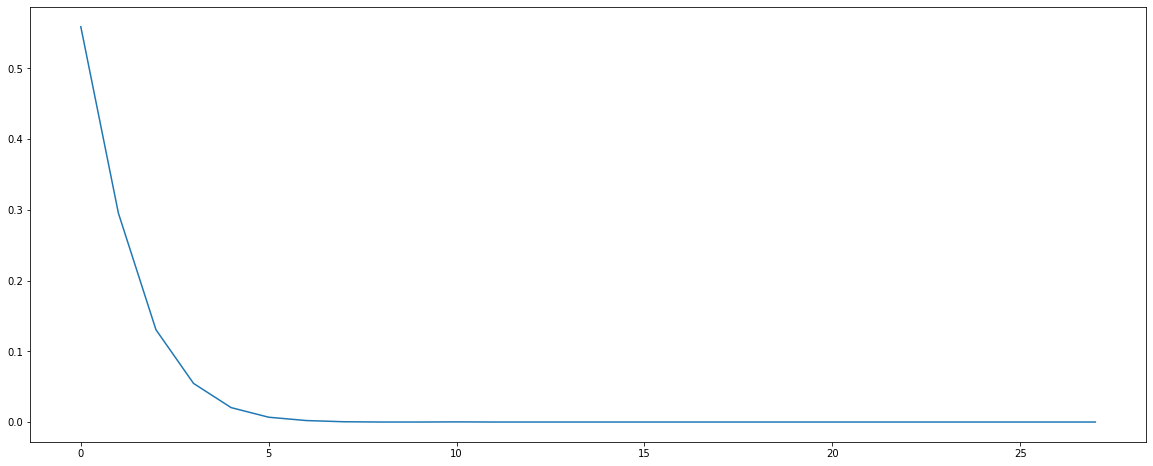

In [ ]:
import pandas as pd
pd.Series(dt_default_mean).plot(figsize=(20,8))

In [ ]:
dt_default_mean

{0: 0.5589,
 1: 0.2954,
 2: 0.1305,
 3: 0.0546,
 4: 0.0204,
 5: 0.0068,
 6: 0.0021,
 7: 0.0004,
 8: 0.0,
 9: 0.0,
 10: 0.0002,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0,
 26: 0.0,
 27: 0.0}

In [ ]:
np.mean(def_vec)

0.2988

# ANS 4)

In [ ]:
import numpy as np
import numpy.random as npr



In [ ]:
def calculate_profit():
  process_1=npr.normal(loc=10,scale=3,size=100)
  process_2=npr.normal(loc=5,scale=2,size=200)

  cost_price=100*10+200*5

  total_chips=np.concatenate([process_1,process_2])

  S_P=np.where(total_chips>=7,15,8)
  selling_price=np.sum(S_P)

  profit=selling_price-cost_price
  return profit
p_lt=[]
for _ in range(10000):
  p_instance=calculate_profit()
  p_lt.append(p_instance)



(array([  1.,   0.,   2.,   0.,   1.,   0.,   0.,   0.,   6.,   0.,   7.,
          0.,   0.,  17.,   0.,  33.,   0.,  38.,   0.,  58.,   0.,  82.,
          0., 113.,   0.,   0., 134.,   0., 203.,   0., 273.,   0., 328.,
          0., 369.,   0., 432.,   0.,   0., 446.,   0., 519.,   0., 573.,
          0., 610.,   0., 650.,   0.,   0., 615.,   0., 598.,   0., 606.,
          0., 536.,   0., 484.,   0., 443.,   0.,   0., 371.,   0., 318.,
          0., 257.,   0., 206.,   0., 177.,   0., 159.,   0.,   0., 102.,
          0.,  62.,   0.,  54.,   0.,  31.,   0.,  38.,   0.,  14.,   0.,
          0.,  12.,   0.,   8.,   0.,   5.,   0.,   5.,   0.,   3.,   0.,
          1.]),
 array([1051.  , 1054.22, 1057.44, 1060.66, 1063.88, 1067.1 , 1070.32,
        1073.54, 1076.76, 1079.98, 1083.2 , 1086.42, 1089.64, 1092.86,
        1096.08, 1099.3 , 1102.52, 1105.74, 1108.96, 1112.18, 1115.4 ,
        1118.62, 1121.84, 1125.06, 1128.28, 1131.5 , 1134.72, 1137.94,
        1141.16, 1144.38, 1147.6 ,

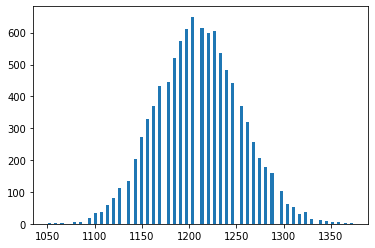

In [ ]:
import matplotlib.pyplot as plt
plt.hist(p_lt,bins=100)

In [ ]:
np.std(p_lt),np.mean(p_lt)

(44.564080241266055, 1210.3235)

# ROUGH WORK

In [ ]:
temp=np.arange(500)
for r in range(n_days):
  even=2*r
  odd=2*r+1
  print('even',temp[5*even:5*even+5])
  print('odd_',odd,temp[5*odd:5*odd+5])
  if r==2:
    break

even [0 1 2 3 4]
odd_ 1 [5 6 7 8 9]
even [10 11 12 13 14]
odd_ 3 [15 16 17 18 19]
even [20 21 22 23 24]
odd_ 5 [25 26 27 28 29]


In [ ]:
  # # hi_to_deal_with=5*r

  # # first_five=A[5*even:5*even+5,:]
  # # second_five=A[5*odd:5*odd+5,:]
  # break


  # # print('even',temp[5*even:5*even+5])
  # # print('odd_',odd,temp[5*odd:5*odd+5])
  # # if r==2:
  # #   break

In [ ]:
# temp[np.index()]